<h1 align="center"> 
DATS 6202, Fall 2018, Midterm_solution
</h1> 

<h4 align="center"> 
Author: Yuxiao Huang ([yuxiaohuang@gwu.edu](mailto:yuxiaohuang@gwu.edu))
</h4>

# Note
- Complete the missing parts indicated by **# Implement me**
- Submit an ipynb file named **Midterm.ipynb** to [blackboard](https://blackboard.gwu.edu) folder /Tests/Midterm/
-  We expect you to follow a reasonable programming style. While we do not mandate a specific style, we require that your code to be neat, clear, **documented/commented** and above all consistent. **Marks will be deducted if these are not followed.**

## 1. Load the Iris dataset

In [1]:
import pandas as pd

# Load the data
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

# Specify the name of the columns
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class']

# Features
features = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width']

# Get the features
X = df[features].values

# Get the target
y = df['Class'].values

In [2]:
from sklearn.preprocessing import LabelEncoder

# The label encoder for the target
le = LabelEncoder()

# Encode the target
y = le.fit_transform(y)

In [3]:
from sklearn.preprocessing import StandardScaler

# The StandardScaler
scaler = StandardScaler()

# Standardize the features
X = scaler.fit_transform(X)

## 2. The power of logistic regression

- Implement the following function, get\_distribution(clf, X, y, feature, class_), which returns a dictionary of a probability distribution of a class label based on a feature (see details in the docstring of the function below)
- **Hint**: The probability distribution is closely related to the sigmoid function:

$$
P(y\ |\ x_1, x_2, \cdots, x_n) = \frac{1}{1 + e^{-z}} \quad \textrm{where} \quad z = w_0 x_0 + w_1 x_1 + \cdots + w_n x_n = \sum^{n}_{i=0} w_i x_i
$$

- **Hint**: The sigmoid function gives the probability distribution of a class based on all the features. 

- **Hint**: <font color='red'>Here is the trick</font>. For each feature $x_j$, when setting the value of all the other features to zero, the sigmoid function mimics the probability distribution of the class based on $x_j$ alone. This is exactly what we want.
- **Hint**: You may consider to implement the function using the following steps:
    - For each feature $x_j$ and class label class_ (two parameters of the function), create a matrix named $\mathrm{X\_sparse}$, which has the exact same number of rows and columns as the feature vector, $\mathrm{X}$ (i.e., if $\mathrm{X}$ is $m \times n$ then so is $\mathrm{X\_sparse}$). Further, all the columns in $\mathrm{X\_sparse}$ are zeros except for the $j$th column, which is exactly the same as the $j$th column in $\mathrm{X}$. By doing this, we set the value of all the features to zero except for $x_j$ (i.e., implementing the trick above).
    - After creating $\mathrm{X\_sparse}$, we loop over each row of the matrix. For each row, we first get the value of the $j$th column. This is the value of feature $x_j$ in the row, which will be used as the key of the dictionary (of the probability distribution). We then pass the row to function clf.[predict_proba(X)](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba) to get the probability of each class label (where clf is a parameter of the function). Last, we get the probablity of the current class label, class_ (a parameter of the function), which will be used as the value of the dictionary.

In [4]:
import numpy as np

def get_distribution(clf, X, y, feature, class_):
    """
    Calculate the probability distribution of a class based on a feature
    :param clf: the logistic regression classifier
    :param X: the feature vector
    :param y: the target vector
    :param feature: a feature
    :param class_: a class label of the target
    :return: the probability distribution, which is a dictionary 
             where the key is the value of the feature and value the probability:
             distribution = {val_1: proba_1, val_2: proba_2, ..., val_n: proba_n}
             
    """
    
    # Get the column number of the feature
    col = features.index(feature)
    
    # Get the encoded number of the class_
    num = le.transform([class_])
    
    # Get X_sparse
    # Here, all the columns are zeros except for column col, where X_sparse[:, col] = X[:, col]
    X_sparse = np.zeros((X.shape[0], X.shape[1]))
    X_sparse[:, col] = X[:, col]
    
    # Get the unique value and the corresponding index in column col
    vals, idxs = np.unique(X_sparse[:, col], return_index=True)
    
    # Get the distribution
    distribution = {}
    # For each unique index
    for idx in idxs:
        # Get the corresponding value
        val = X_sparse[idx, col]
        
        # Get the probability of each class
        probas = clf.predict_proba(X_sparse[idx, :].reshape(1, -1)).ravel()

        # Get the probability of the class
        proba = probas[num]
        
        distribution[val] = proba
        
    return distribution

In [5]:
import matplotlib.pyplot as plt

def plot_distribution(distribution, feature, class_):
    """
    Plot the probability distribution of a class based on the feature
    :param distribution: the probability distribution, which is a dictionary 
                         where the key is the value of the feature and value the probability:
                         distribution = {val_1: proba_1, val_2: proba_2, ..., val_n: proba_n}
    :param feature: a feature
    :param class_: a class label of the target
    """
    
    # Get the probabilities
    probas = [distribution[val] for val in sorted(distribution.keys())]
    
    # Get the dataframe
    probas_df = pd.DataFrame(probas)
    
    # Get the values
    vals = sorted(distribution.keys())
    
    # Round down to 2 decimals
    vals = [round(val, 2) for val in vals]

    # Plot the bar chart
    probas_df.plot(kind='bar', figsize=(25, 10), fontsize=30, legend=False)
    plt.xticks(range(len(vals)), vals)
    plt.xlabel('Feature value', fontsize=30)
    plt.ylabel('Probability', fontsize=30)
    plt.title('P(' + class_ + ' | ' + feature + ')', fontsize=30, loc='center')
    plt.tight_layout()
    plt.show()

In [6]:
from sklearn.linear_model import LogisticRegression

# Declare the classifier
clf = LogisticRegression(multi_class='multinomial', solver='newton-cg', random_state=0)

# Train the classifier
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

## 3.1 The probability distribution of 'Iris-setosa' based on 'Petal length'

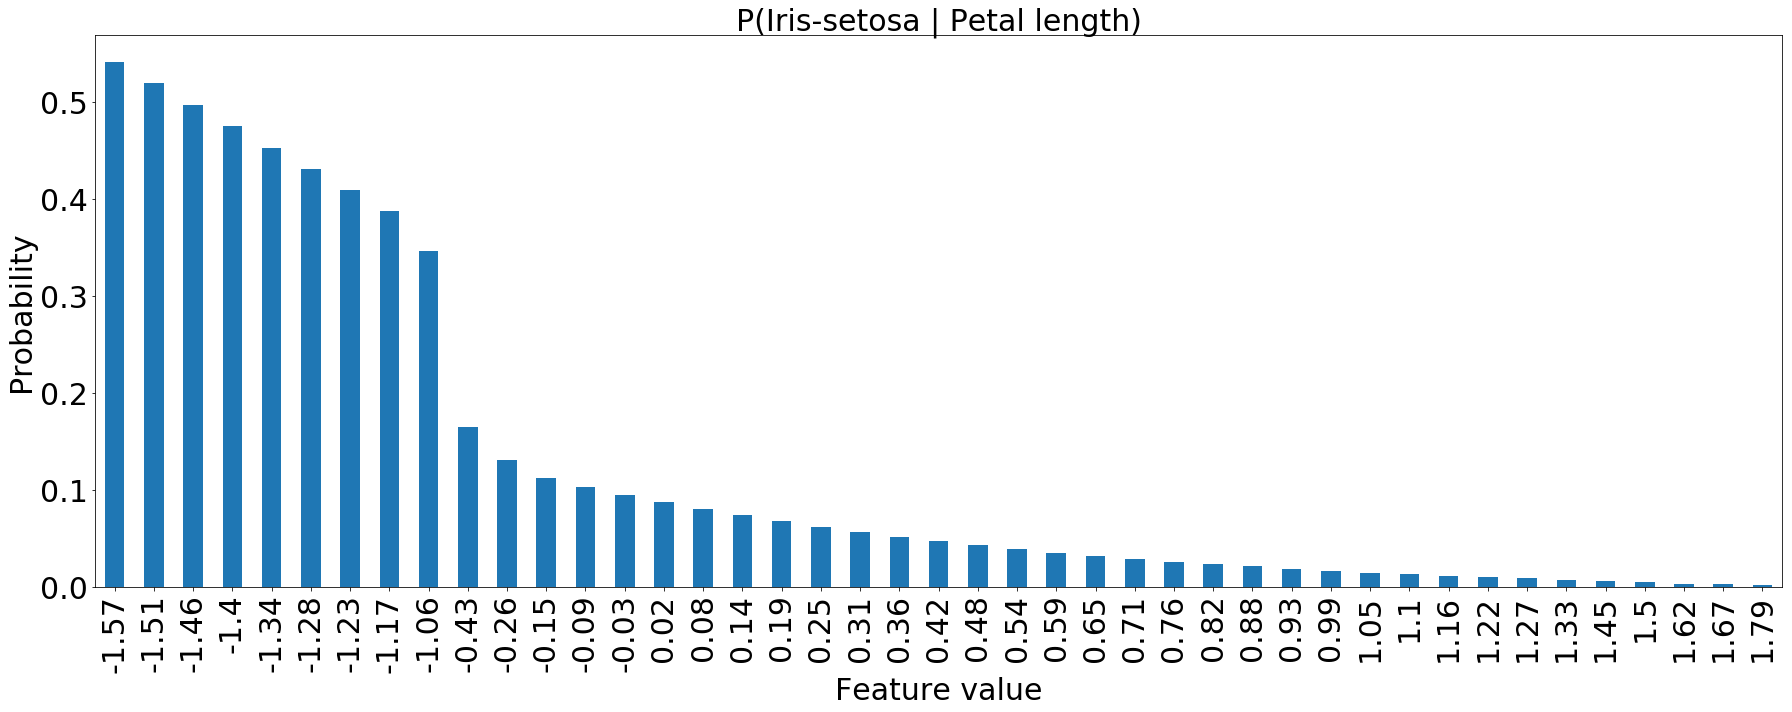

In [7]:
# Get the distribution
distribution = get_distribution(clf, X, y, "Petal length", "Iris-setosa")

# Plot the distribution
plot_distribution(distribution, "Petal length", "Iris-setosa")

## 3.2 The probability distribution of 'Iris-setosa' based on 'Petal width'

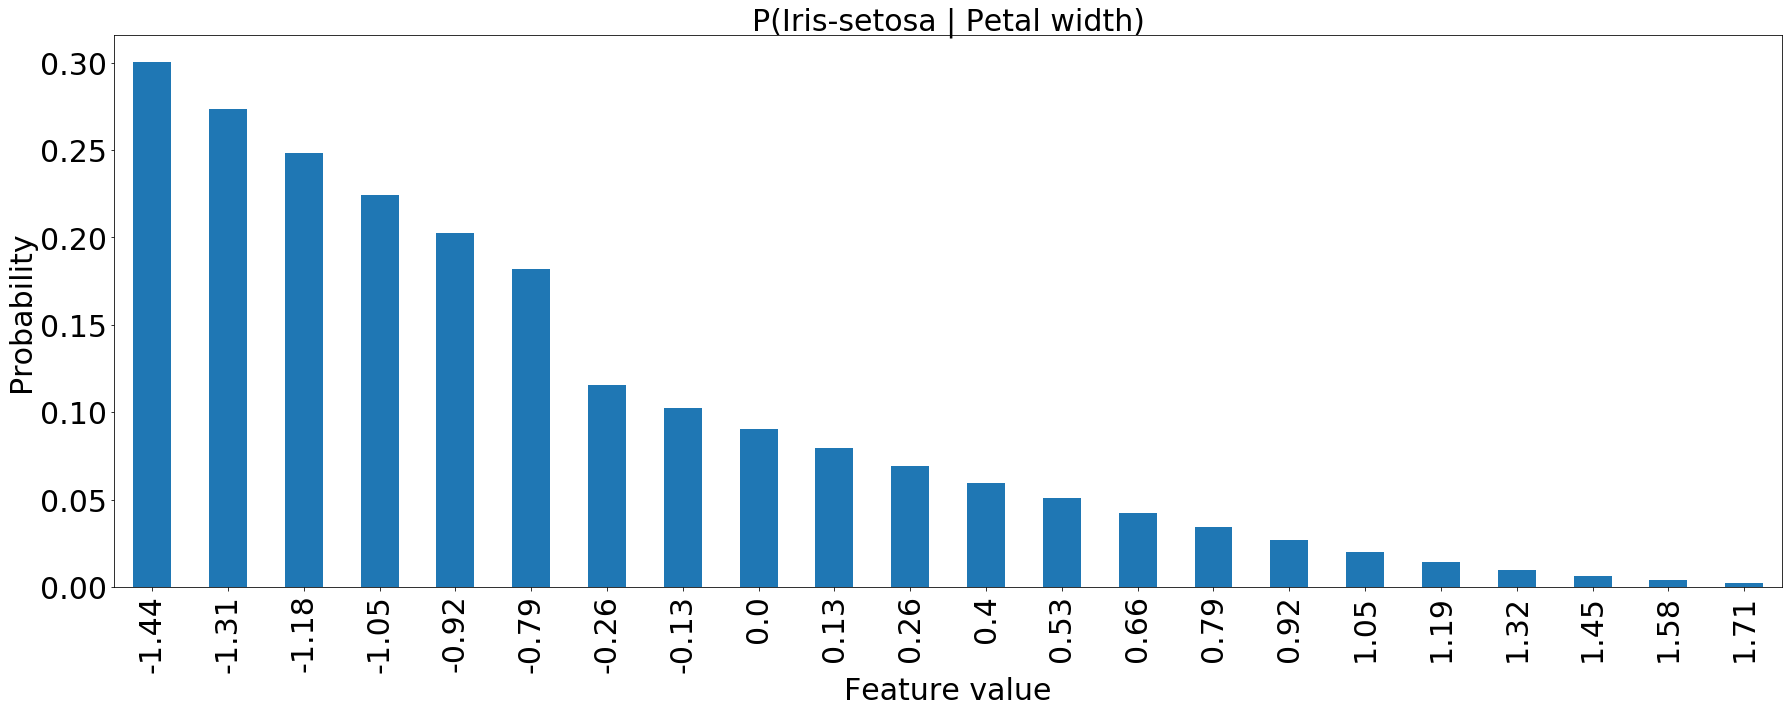

In [8]:
# Get the distribution
distribution = get_distribution(clf, X, y, "Petal width", "Iris-setosa")

# Plot the distribution
plot_distribution(distribution, "Petal width", "Iris-setosa")

## 3.3 The probability distribution of 'Iris-versicolor' based on 'Petal length' 

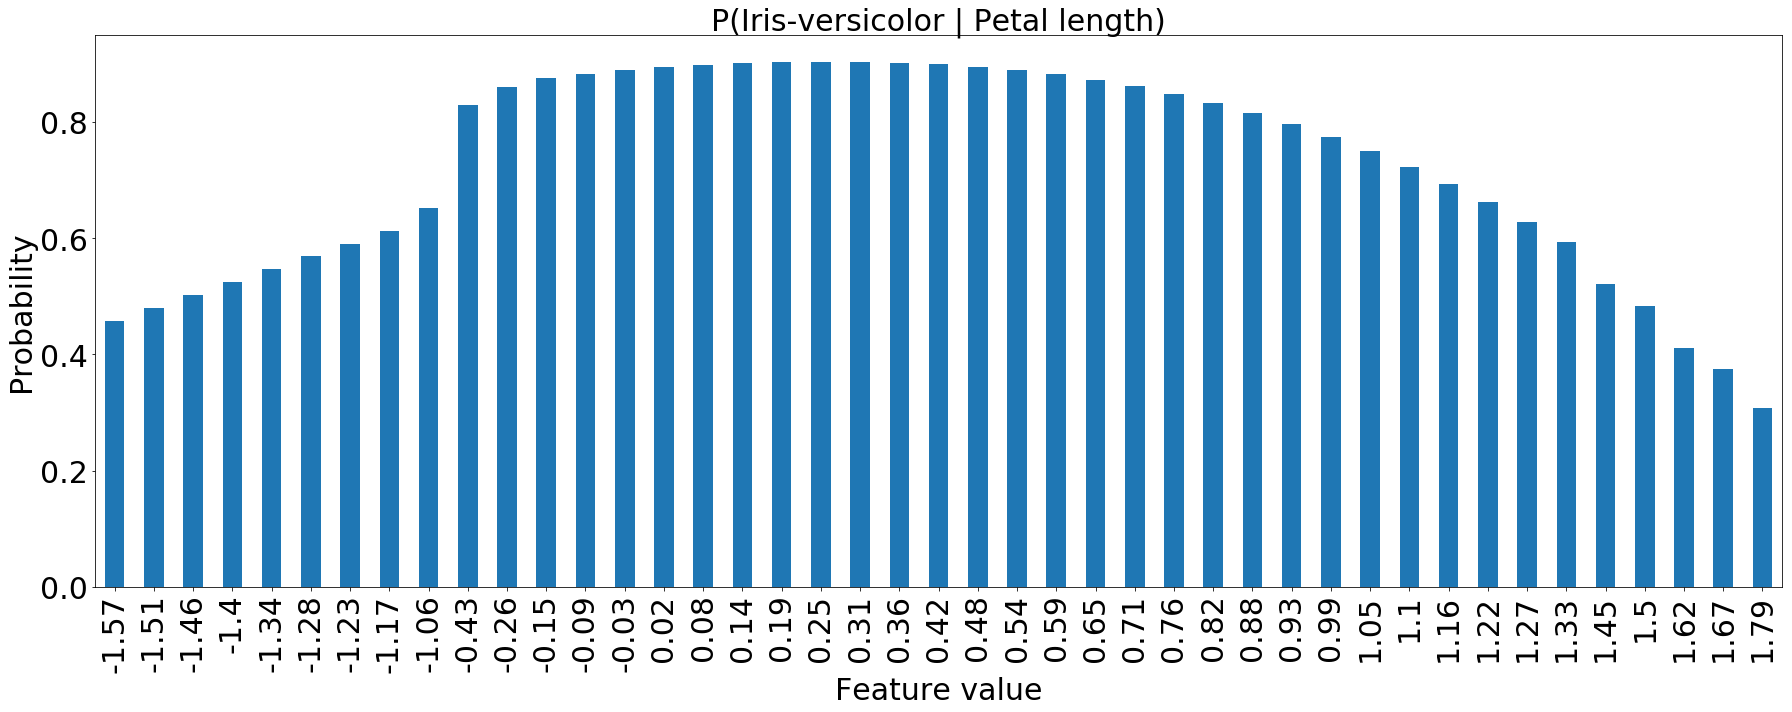

In [9]:
# Get the distribution
distribution = get_distribution(clf, X, y, "Petal length", "Iris-versicolor")

# Plot the distribution
plot_distribution(distribution, "Petal length", "Iris-versicolor")

## 3.4 The probability distribution of 'Iris-versicolor' based on 'Petal width' 

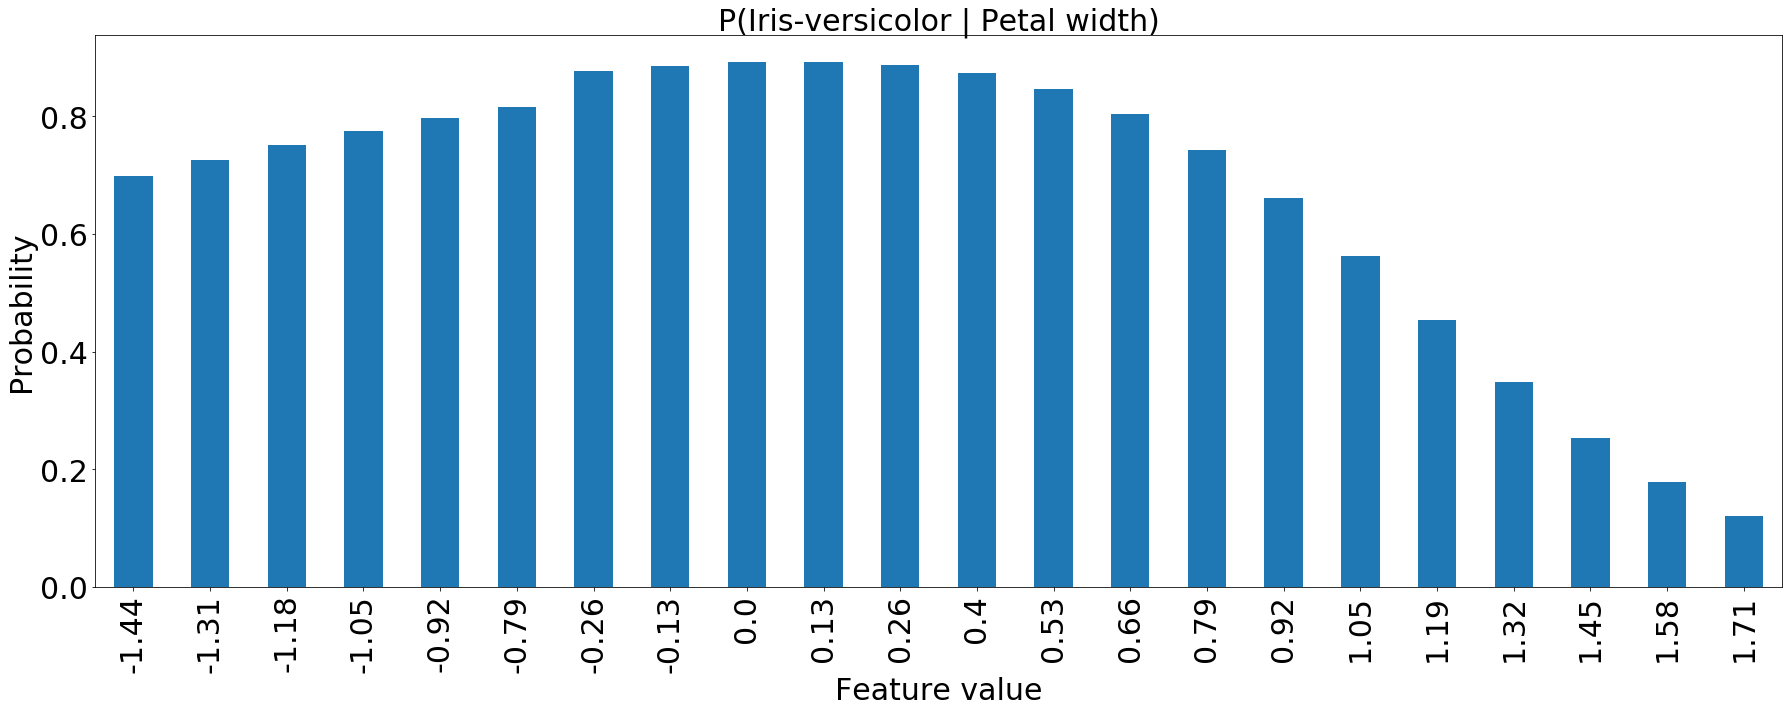

In [10]:
# Get the distribution
distribution = get_distribution(clf, X, y, "Petal width", "Iris-versicolor")

# Plot the distribution
plot_distribution(distribution, "Petal width", "Iris-versicolor")

## 3.5 The probability distribution of 'Iris-virginica' based on 'Petal length' 

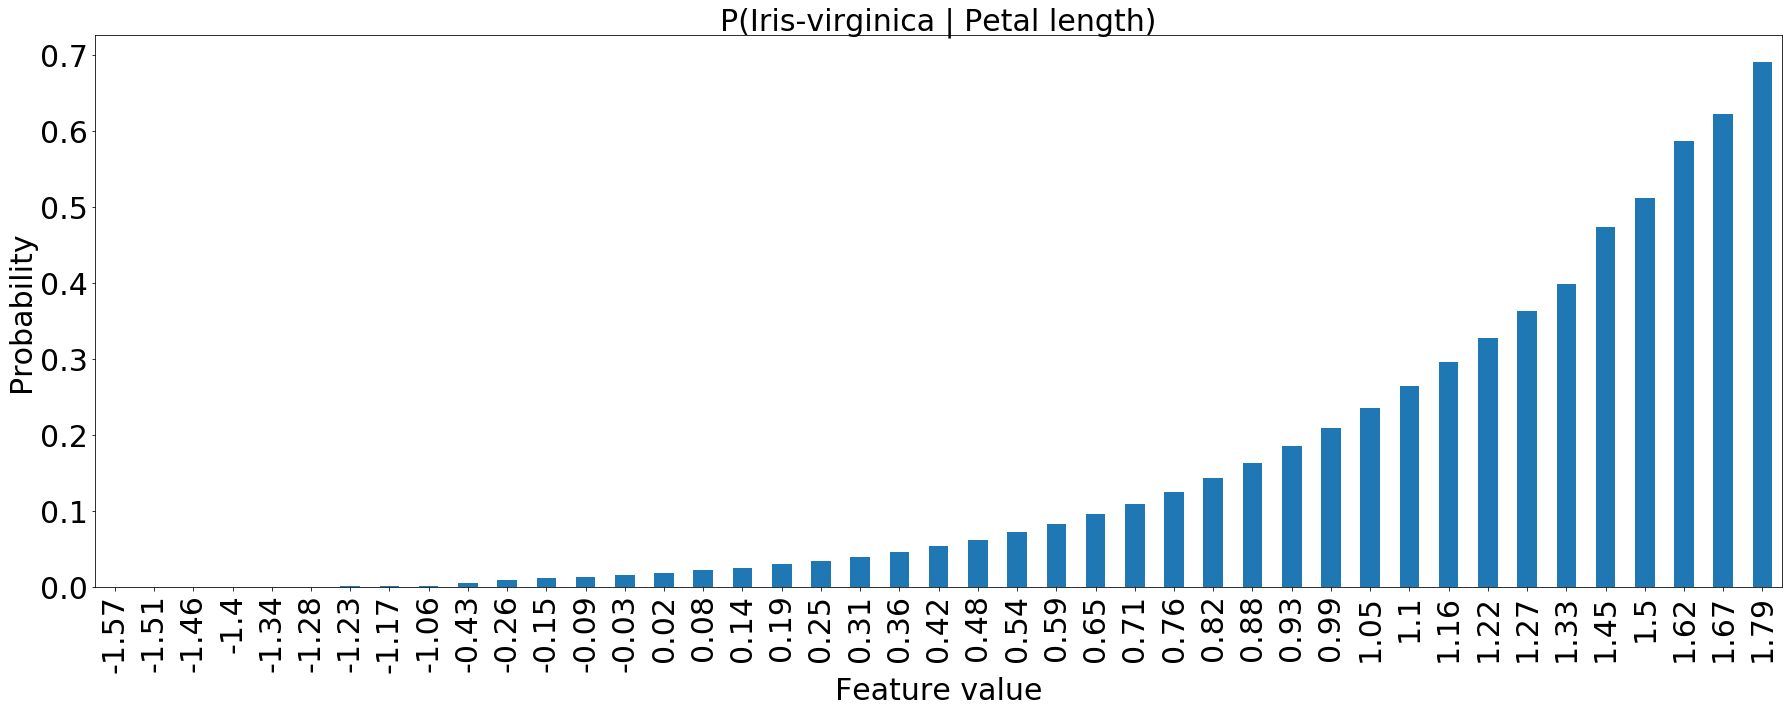

In [11]:
# Get the distribution
distribution = get_distribution(clf, X, y, "Petal length", "Iris-virginica")

# Plot the distribution
plot_distribution(distribution, "Petal length", "Iris-virginica")

## 3.6 The probability distribution of 'Iris-virginica' based on 'Petal width' 

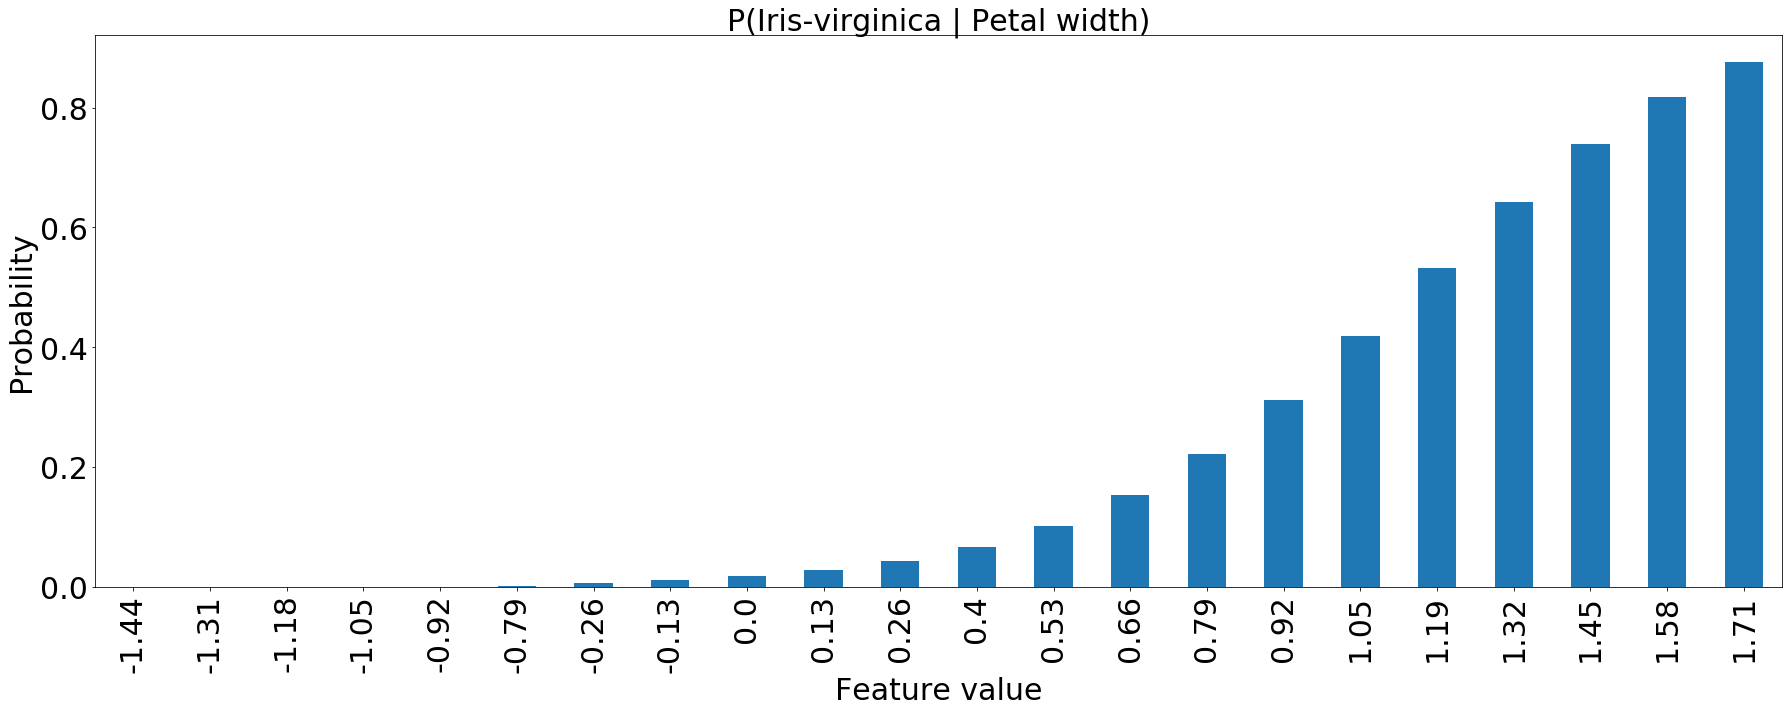

In [12]:
# Get the distribution
distribution = get_distribution(clf, X, y, "Petal width", "Iris-virginica")

# Plot the distribution
plot_distribution(distribution, "Petal width", "Iris-virginica")

## 4. Do the above distributions make sense?

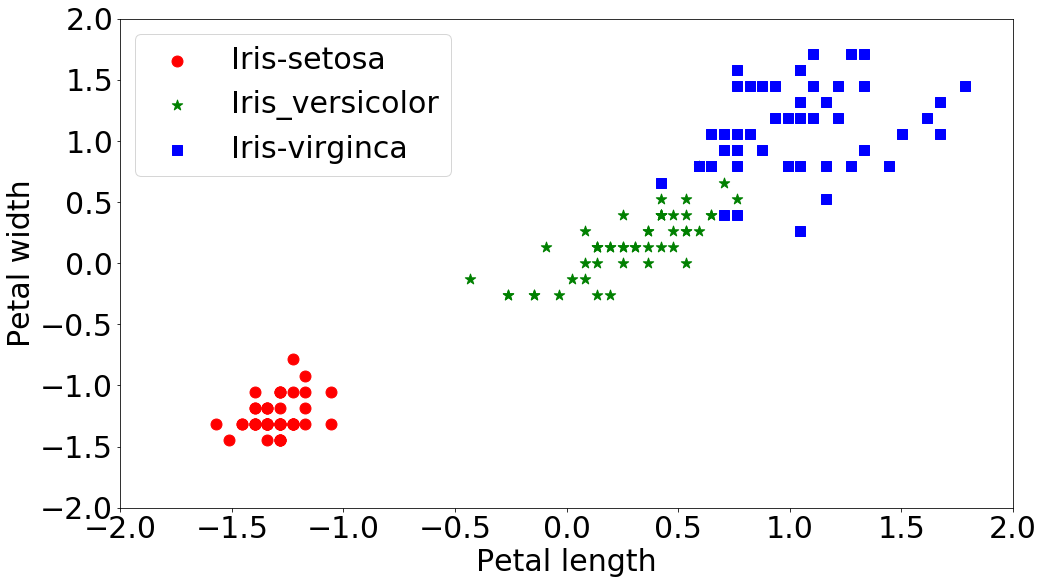

In [13]:
# Get the x values
x_col = features.index('Petal length')
x_vals = X[:, x_col]

# Get the y values
y_col = features.index('Petal width')
y_vals = X[:, y_col]

# Get the color, marker, and class
colors = ["red", "green", "blue"]
markers = ["o", "*", "s"]
classes = ["Iris-setosa", "Iris_versicolor", "Iris-virginca"]

# Get the data
data = {}
for num in range(3):
    data_x = [x_vals[i] for i in range(len(y)) if y[i] == num]
    data_y = [y_vals[i] for i in range(len(y)) if y[i] == num]
    data[num] = [data_x, data_y]

# Scatter plot
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(1, 1, 1)
 
for num, color, marker, class_ in zip(data.keys(), colors, markers, classes):
    x, y = data[num]
    ax.scatter(x, y, c=color, marker=marker, s=120, label=class_)

plt.xlabel('Petal length', fontsize=30)
plt.ylabel('Petal width', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.legend(loc=2, fontsize=30)
plt.show()

- The above scatter plot shows that for class 'Iris-setosa' (the red circles), it is largely determined by low values of the two features, 'Petal length' and 'Petal width'. However, class 'Iris-versicolor' (the green stars) is mainly decided by medium values of the two features, and 'Iris-virginca' (blue squares) by high values.

- This variation is captured by the above distributions. Specifically for class 'Iris-setosa', the probabilities are higher when the two features take low values, whereas for 'Iris-versicolor' and 'Iris-virginca', the probabilities are higher when the two features take medium and high values.

- So the distributions do make sense!